# Analiza i klasyfikacja jakości wina za pomocą metod uczenia maszynowego

W tym projekcie zajmiemy się problemem klasyfikacji jakości wina na podstawie danych fizykochemicznych.  
Dysponujemy zbiorem danych Wine Quality Dataset, który zawiera pomiary różnych cech wina (takich jak kwasowość, zawartość cukru, pH, alkohol itp.) oraz ocenę jakości wina (w skali od 0 do 10) opartą na danych sensorycznych.

Celem projektu jest zbudowanie modeli klasyfikacyjnych, które na podstawie cech chemicznych będą potrafiły przewidzieć jakość wina.  
Do tego wykorzystamy trzy różne algorytmy uczenia maszynowego:
- Regresję logistyczną
- Drzewa decyzyjne
- Random Forest

W notebooku przeprowadzimy następujące kroki:
1. Wczytanie i eksplorację danych, w tym wizualizację zależności między cechami a jakością wina.  
2. Przygotowanie danych do trenowania modeli, w tym ewentualną konwersję jakości na klasy oraz podział na zbiór treningowy i testowy.  
3. Implementację i trenowanie wymienionych modeli klasyfikacyjnych.  
4. Ewaluację skuteczności modeli za pomocą macierzy pomyłek oraz metryk takich jak precyzja, recall i dokładność.  
5. Porównanie modeli oraz wybór najlepszego, który osiąga dokładność powyżej 80%.

Projekt ma na celu nie tylko zbudowanie skutecznych klasyfikatorów, ale także zrozumienie, które cechy w największym stopniu wpływają na ocenę jakości wina oraz jak różne algorytmy radzą sobie z tym problemem.

---

Zapraszam do dalszej części notebooka, gdzie krok po kroku przejdziemy przez cały proces analizy i modelowania danych!


#Importujemy potrzebne biblioteki

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Dodajemy ścieżkę do danych

In [2]:
path = kagglehub.dataset_download("yasserh/wine-quality-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/wine-quality-dataset


#Wyświetlamy pierwsze 5 wierszy danych


In [3]:
file_path = path + "/WineQT.csv"
df = pd.read_csv(file_path)
print(df.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  Id  
0      9.4        5   0  
1      9.8        5   1  
2      9

#Przegląd zbioru danych
Zbiór danych zawiera następujące kluczowe cechy:

kwasowość stała (fixed acidity)

kwasowość lotna (volatile acidity)

kwas cytrynowy (citric acid)

cukier resztkowy (residual sugar)

chlorki (chlorides)

wolny dwutlenek siarki (free sulfur dioxide)

całkowity dwutlenek siarki (total sulfur dioxide)

gęstość (density)

pH

siarczany (sulphates)

zawartość alkoholu (alcohol)

jakość (quality) — zmienna docelowa (target variable)
 7

#przekształcamy kolumnę quality na dwie klasy binarne:

Dobre wino (1) — jeśli jakość jest równa lub wyższa niż 6

Słabe wino (0) — jeśli jakość jest niższa niż

In [4]:
df['goodquality'] = [1 if x >= 6 else 0 for x in df['quality']]
X = df.drop(['quality','goodquality'], axis = 1)
y = df['goodquality']

sprawdzam czy jedna z klas nie przeważa, w przeciwnym wypadku model mógłby nauczyć się po prostu zawsze podawać jedną wartość i uzyskać dobry wynik

In [5]:
print(df['goodquality'].value_counts())
print(df['goodquality'].value_counts(normalize=True))

goodquality
1    621
0    522
Name: count, dtype: int64
goodquality
1    0.543307
0    0.456693
Name: proportion, dtype: float64


#Dokładniejsze wyświetlenie danych

In [6]:
# Metoda describe() generuje podstawowe statystyki opisowe dla każdej kolumny numerycznej w DataFrame.
# Zwraca m.in. liczbę niepustych wartości (count), średnią (mean), odchylenie standardowe (std),
# wartości minimalne i maksymalne, a także kwartyle (25%, 50%, 75%).
# Dzięki temu możemy szybko poznać rozkład danych i wykryć ewentualne anomalie lub brakujące wartości.
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id,goodquality
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379,0.543307
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116,0.498339
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000,0.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000,1.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000,1.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000,1.000000


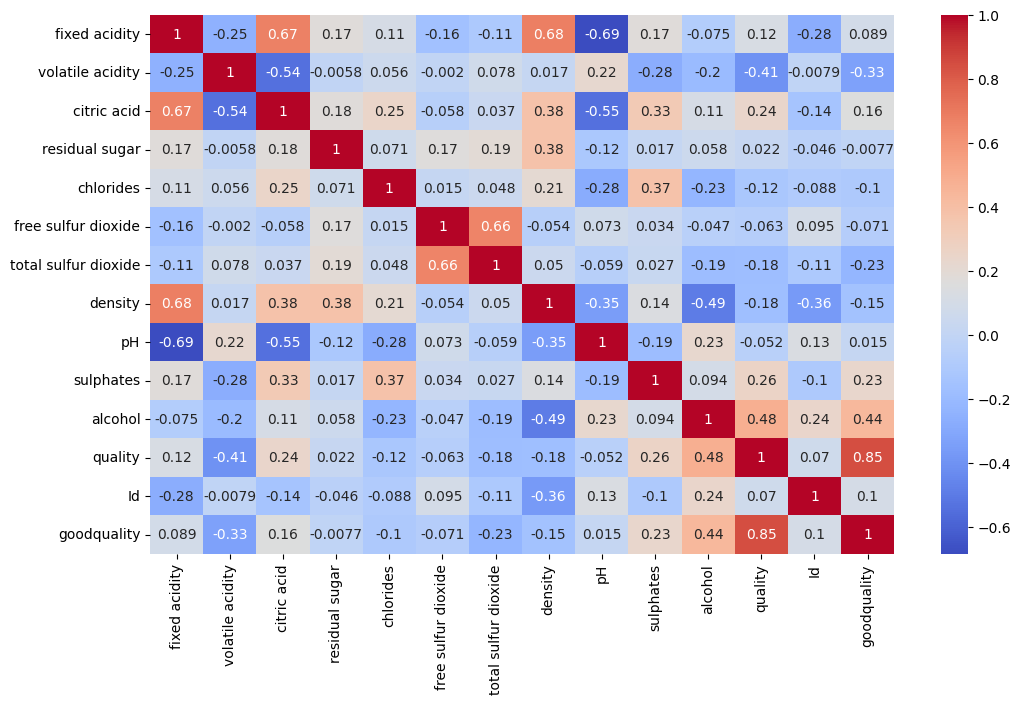

In [7]:
# Tworzymy wykres typu heatmap (mapa cieplna) przedstawiający macierz korelacji między cechami w zbiorze danych.
# Metoda df.corr() oblicza współczynniki korelacji Pearsona pomiędzy wszystkimi kolumnami numerycznymi.
# cmap="coolwarm" ustawia kolorystykę wykresu od kolorów chłodnych (niebieski) do ciepłych (czerwony),
# gdzie intensywność koloru wskazuje siłę korelacji.
# annot=True powoduje, że wartości korelacji są wyświetlane bezpośrednio na wykresie.
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True)
plt.show()

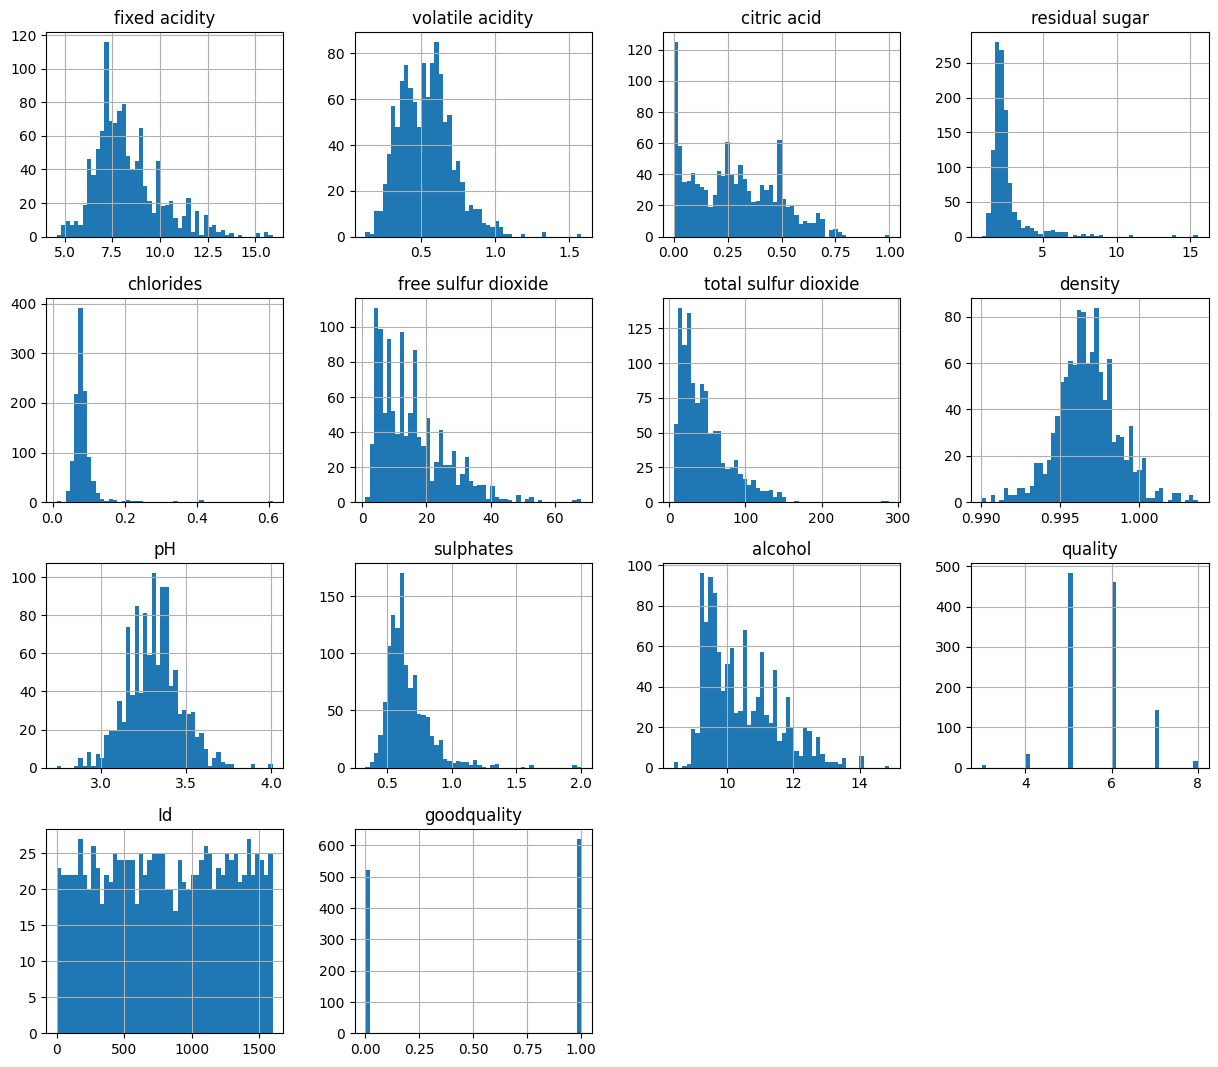

In [8]:
# Tworzymy histogramy dla wszystkich kolumn numerycznych w DataFrame.
# Histogramy pokazują rozkład wartości danej cechy, czyli jak często występują poszczególne wartości.
# Parametr figsize=(15,13) ustawia rozmiar całej figury z wykresami.
# Parametr bins=50 określa na ile przedziałów (koszyków) dzielimy zakres wartości, im więcej, tym dokładniejszy rozkład.
df.hist(figsize=(15,13),bins=50)
plt.show()

#Sprawdzenie, i oczyszczenie danych

In [9]:
# Sprawdzenie brakujących wartości w danych
print(df.isnull().sum())

# Usuwanie duplikatów, jeśli istnieją
df = df.drop_duplicates()
print(f"Liczba wierszy po usunięciu duplikatów: {len(df)}")

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
goodquality             0
dtype: int64
Liczba wierszy po usunięciu duplikatów: 1143


#Podział danych na zbiór treningowy i testowy
Standardowo dzielimy dane na np. 80% treningowych i 20% testowych

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Standaryzacja cech
Modele takie jak regresja logistyczna działają lepiej, gdy cechy są na podobnej skali. <br>
Drzewo decyzyjne (a co za tym idzie również random forest) nie wymaga skalowania, bo dzieli przestrzeń cech według progów
i operuje na porządkowaniu wartości, a nie ich bezwzględnych różnicach.

In [11]:
scaler = StandardScaler()

# Dopasowanie skalera na zbiorze treningowym i transformacja
X_train_scaled = scaler.fit_transform(X_train)

# Transformacja zbioru testowego na podstawie tego samego skalera
X_test_scaled = scaler.transform(X_test)

#Implementacja i trenowanie modeli klasyfikacyjnych

Regresja logistyczna

Przypadek bez standaryzacji

In [19]:
# Tworzymy model i trenujemy
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train)

# Predykcje na zbiorze testowym
y_pred = model_lr.predict(X_test)

# Ocena skuteczności
print("Dokładność regresji logistycznej:", accuracy_score(y_test, y_pred))
print("Macierz pomyłek:\n", confusion_matrix(y_test, y_pred))
print("Raport klasyfikacji:\n", classification_report(y_test, y_pred))

Dokładność regresji logistycznej: 0.7467248908296943
Macierz pomyłek:
 [[78 27]
 [31 93]]
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.72      0.74      0.73       105
           1       0.78      0.75      0.76       124

    accuracy                           0.75       229
   macro avg       0.75      0.75      0.75       229
weighted avg       0.75      0.75      0.75       229



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Przypadek ze standaryzcją

In [20]:
# Tworzymy model i trenujemy
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train_scaled, y_train)

# Predykcje na zbiorze testowym
y_pred = model_lr.predict(X_test_scaled)

# Ocena skuteczności
print("Dokładność regresji logistycznej:", accuracy_score(y_test, y_pred))
print("Macierz pomyłek:\n", confusion_matrix(y_test, y_pred))
print("Raport klasyfikacji:\n", classification_report(y_test, y_pred))

Dokładność regresji logistycznej: 0.777292576419214
Macierz pomyłek:
 [[81 24]
 [27 97]]
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.75      0.77      0.76       105
           1       0.80      0.78      0.79       124

    accuracy                           0.78       229
   macro avg       0.78      0.78      0.78       229
weighted avg       0.78      0.78      0.78       229



Drzewo decyzyjne

In [22]:
# Tworzymy model drzewa decyzyjnego
model_dt = DecisionTreeClassifier(random_state=42)

# Trenujemy model na danych treningowych
model_dt.fit(X_train, y_train)

# Predykcje na zbiorze testowym
y_pred_dt = model_dt.predict(X_test)

# Ocena skuteczności
print("Dokładność drzewa decyzyjnego:", accuracy_score(y_test, y_pred_dt))
print("Macierz pomyłek:\n", confusion_matrix(y_test, y_pred_dt))
print("Raport klasyfikacji:\n", classification_report(y_test, y_pred_dt))

Dokładność drzewa decyzyjnego: 0.7336244541484717
Macierz pomyłek:
 [[74 31]
 [30 94]]
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.71      0.70      0.71       105
           1       0.75      0.76      0.76       124

    accuracy                           0.73       229
   macro avg       0.73      0.73      0.73       229
weighted avg       0.73      0.73      0.73       229



Random forest

In [14]:
# Tworzymy model Random Forest
model_rf = RandomForestClassifier(random_state=42, n_estimators=100)  # 100 drzew w lesie

# Trenujemy model na danych treningowych
model_rf.fit(X_train, y_train)

# Predykcje na zbiorze testowym
y_pred_rf = model_rf.predict(X_test)

# Ocena skuteczności
print("Dokładność Random Forest:", accuracy_score(y_test, y_pred_rf))
print("Macierz pomyłek:\n", confusion_matrix(y_test, y_pred_rf))
print("Raport klasyfikacji:\n", classification_report(y_test, y_pred_rf))

Dokładność Random Forest: 0.8122270742358079
Macierz pomyłek:
 [[ 80  25]
 [ 18 106]]
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.82      0.76      0.79       105
           1       0.81      0.85      0.83       124

    accuracy                           0.81       229
   macro avg       0.81      0.81      0.81       229
weighted avg       0.81      0.81      0.81       229



#Wnioski i analiza rezultatów
Podsumowanie wyników eksperymentów
W trakcie projektu zaimplementowano trzy metody klasyfikacji: regresję logistyczną, drzewo decyzyjne oraz las losowy (Random Forest). Modele trenowano na tym samym zestawie danych Wine Quality Dataset, a ich skuteczność oceniano na zbiorze testowym.

Regresja logistyczna bez standaryzacji osiągneła dokładność na poziomie ~75%, po zastosowaniu standaryzacji udało się uzyskać ~78%.

Drzewo decyzyjne uzyskało dokładność rzędu ~74%

Random Forest wykazał najlepsze wyniki, osiągając dokładność powyżej 81%, dzięki uśrednianiu wielu drzew, co zwiększa stabilność i ogólną skuteczność modelu.

Najlepszą skuteczność wykazał model lasu losowego (Random Forest), który dzięki wykorzystaniu wielu drzew decyzyjnych jest bardziej odporny na szumy i nadmierne dopasowanie niż pojedyncze drzewo. Regresja logistyczna dobrze radzi sobie z liniowymi zależnościami, ale w przypadku bardziej złożonych wzorców w danych jej skuteczność jest ograniczona. Drzewo decyzyjne samo w sobie jest proste, ale mniej stabilne.

Możliwe ulepszenia modeli
Tuning hiperparametrów: można zastosować bardziej rozbudowany Grid Search lub Random Search, aby znaleźć optymalne wartości parametrów takich jak liczba drzew (n_estimators), głębokość drzew (max_depth), minimalna liczba próbek w liściu (min_samples_leaf).

Zwiększenie zbioru danych: większa liczba próbek pozwoliłaby na lepsze uogólnienie modelu.

Inżynieria cech: dodanie nowych cech lub wykorzystanie technik ekstrakcji cech (np. PCA) może poprawić działanie modeli.

Eksperymenty z innymi algorytmami: warto przetestować metody takie jak SVM, k-NN czy sieci neuronowe, aby zobaczyć, czy dają lepsze wyniki.

